In [35]:
# --- Importe und Grundkonfiguration ----------------------------------------------
# Importiert das Betriebssystem-Modul für Verzeichnisprüfungen und -erstellung
import os
# Importiert NumPy für numerische Operationen und die Behandlung von NaN während der Bereinigung
import numpy as np
# Importiert pandas als zentrales Toolkit für tabellarische Datenverarbeitung
import pandas as pd
# Importiert GeoPandas für die Arbeit mit Geodaten wie dem Gemeinde-GeoJSON
import geopandas as gpd
# Importiert Matplotlibs Pyplot-Schnittstelle für Diagramme und Karten
import matplotlib.pyplot as plt
# Importiert Seaborn für höherwertige statistische Visualisierungen und Styling
import seaborn as sns

# Stellt sicher, dass alle Ausgabeverzeichnisse existieren, damit spätere Speicheroperationen nicht scheitern
os.makedirs('/home/jovyan/work/outputs', exist_ok=True)
# Erzeugt bei Bedarf den Karten-Unterordner im Outputs-Verzeichnis
os.makedirs('/home/jovyan/work/outputs/maps', exist_ok=True)
# Legt den Unterordner für erzeugte Abbildungen an, damit Scatterplots und Heatmaps gespeichert werden können
os.makedirs('/home/jovyan/work/outputs/figures', exist_ok=True)

# Gibt direkt Rückmeldung, dass die Umgebung erfolgreich vorbereitet wurde
print('Environment ready.')



Environment ready.


In [36]:
# --- Datensätze laden -------------------------------------------------------------
# Definiert den CSV-Pfad mit gemeindescharfen Stromverbrauchsdaten inklusive Zeitstempeln
energy_path = '/home/jovyan/work/datasets/energyreporter_municipality_historized.csv'
# Bestimmt den Semikolon-separierten CSV-Pfad mit Steuerstatistiken zu Einkommen und Vermögen
wealth_path = '/home/jovyan/work/datasets/data_7354970.csv'
# Legt den GeoJSON-Pfad der Gemeindegrenzen fest, die für Karten benötigt werden
geojson_path = '/home/jovyan/work/datasets/zh-municipalities.geojson'

# Liest die Energie-CSV ein und wandelt die Datumsspalte sofort in Datetime-Objekte für Filterungen um
energy = pd.read_csv(energy_path, parse_dates=['energyreporter_date'])
# Liest die Vermögensstatistik-CSV ein, deren Felder durch Semikolon getrennt sind
wealth = pd.read_csv(wealth_path, sep=';')

# Setzt den Platzhalter für den GeoDataFrame auf None, damit später geprüft werden kann, ob Geometrien vorliegen
geo = None
# Lädt das GeoJSON nur, falls die Datei existiert, um unnötige Fehler zu vermeiden
if os.path.exists(geojson_path):
    try:
        # Verwendet GeoPandas, um die Gemeindepolygone samt Attributen zu laden
        geo = gpd.read_file(geojson_path)
        # Lädt das GeoJSON zusätzlich mit dem json-Modul, um die als BFS-Nummern genutzten Feature-IDs zu extrahieren
        import json
        # Öffnet das GeoJSON manuell, um die Roh-Features samt ID-Feldern auszulesen
        with open(geojson_path, 'r') as f:
            geojson_data = json.load(f)
        # Liest die ID-Felder des GeoJSON und bildet daraus BFS-Nummern für den GeoDataFrame
        bfs_nrs = [f.get('id', idx) for idx, f in enumerate(geojson_data.get('features', []))]
        # Schreibt die extrahierten BFS-Nummern in den GeoDataFrame, um spätere Joins zu ermöglichen
        geo['bfs_nr'] = bfs_nrs
        # Meldet, wie viele Geometrien erfolgreich geladen wurden
        print(f'GeoJSON loaded: {len(geo)} features')
    except Exception as e:
        # Informiert den Nutzer über GeoJSON-Ladefehler und schaltet in den Modus ohne Geodaten
        print(f'Warning: Failed to load GeoJSON: {e}')
        # Setzt geo im Fehlerfall ausdrücklich auf None, damit spätere Kartenschritte übersprungen werden können
        geo = None
else:
    # Meldet, dass keine Karten erstellt werden können, falls das GeoJSON fehlt
    print('Info: GeoJSON not found; maps will be skipped until provided.')

# Gibt die Dimensionen der Datensätze sowie den Status der Geo-Ebene als schnellen Plausibilitätscheck aus
print(energy.shape, wealth.shape, 'geo loaded' if geo is not None else 'no geo')



GeoJSON loaded: 171 features
(119844, 35) (17176, 12) geo loaded


In [37]:
# --- Zürich-spezifische Datenausschnitte filtern und Schlüssel harmonisieren -------
# Filtert auf den Kanton ZH und behält nur die wesentlichen Spalten inklusive beider Energievarianten und Zeitstempel
energy_zh = energy.loc[energy['canton'] == 'ZH', [
    'bfs_nr',
    'municipality',
    'energyreporter_date',
    'elec_consumption_mwh_per_year_per_capita',
    'elec_consumption_households_mwh_per_year_per_capita'
]].copy()
# Erzwingt Integer-BFS-Nummern im Energiedatensatz, damit spätere Joins typkonsistent sind
energy_zh['bfs_nr'] = energy_zh['bfs_nr'].astype(int)

# Schneidet die Vermögenstabelle auf die später benötigten Identifikatoren und Metadaten zu
wealth_small = wealth.loc[:, ['BFS_NR', 'GEBIET_NAME', 'INDIKATOR_ID', 'INDIKATOR_NAME', 'INDIKATOR_JAHR', 'INDIKATOR_VALUE']].copy()
# Wandelt auch die BFS-Spalte des Vermögensdatensatzes in Integer um, damit der Typ zum Energietableau passt
wealth_small['BFS_NR'] = wealth_small['BFS_NR'].astype(int)

# Erstellt eine Zuordnung von BFS-Nummern zu Gemeindenamen auf Basis der zuverlässigen Energiedaten
municipality_lookup = energy_zh[['bfs_nr', 'municipality']].drop_duplicates(subset='bfs_nr')

# Stellt bei vorhandenen Geometrien sicher, dass BFS-Nummern numerisch sind, und protokolliert deren Spannweite
if geo is not None:
    # Wandelt BFS-Zeichenketten im GeoDataFrame in den nullable Integer-Typ um und erzwingt NaN für Ungültiges
    geo['bfs_nr'] = pd.to_numeric(geo['bfs_nr'], errors='coerce').astype('Int64')
    # Gibt diagnostisch an, wie viele Geometrien vorhanden sind und welchen BFS-Bereich sie abdecken
    print(f'GeoJSON: {len(geo)} features, bfs_nr range: {geo["bfs_nr"].min()}-{geo["bfs_nr"].max()}')

# Gibt die resultierenden Zeilenzahlen als Plausibilitätscheck vor den Aggregationen aus
print(energy_zh.shape, wealth_small.shape)



GeoJSON: 171 features, bfs_nr range: 1-9051
(9004, 5) (17176, 6)


In [38]:
# --- Aggregation der Energiekennzahlen 2024 -----------------------------------------
# Begrenzt die Energiedaten auf 2024, damit sie zeitlich zu den Vermögenswerten von 2022 passen
energy_2024 = energy_zh[energy_zh['energyreporter_date'].dt.year == 2024].copy()
# Gruppiert nach Gemeinde und berechnet den Jahresmittelwert für Gesamt- und Haushaltsstrom
consum = (
          energy_2024
          .groupby('bfs_nr', as_index=False)
          .agg({
              'elec_consumption_mwh_per_year_per_capita': 'mean',
              'elec_consumption_households_mwh_per_year_per_capita': 'mean'
          })
          # Benennt die aggregierten Spalten so um, dass Jahr und Verbrauchsart klar hervorgehen
          .rename(columns={
              'elec_consumption_mwh_per_year_per_capita': 'total_elec_per_capita_mwh_2024',
              'elec_consumption_households_mwh_per_year_per_capita': 'household_elec_per_capita_mwh_2024'
          }))

# Gibt die ersten Zeilen der aggregierten Tabelle zur schnellen Sichtprüfung aus
consum.head()



,bfs_nr,total_elec_per_capita_mwh_2024,household_elec_per_capita_mwh_2024
0,1,4.495275,2.970700
1,2,4.198583,1.678750
2,3,2.789025,1.738283
3,4,3.874125,2.251017
4,5,5.465508,2.169908


In [39]:
# --- Vermögenskennzahlen 2022 extrahieren und in ein Wide-Format überführen ---------
# Filtert die Vermögensindikatoren auf das Berichtsjahr 2022, um mit den aktuellsten Steuerdaten zu arbeiten
wealth_2022 = wealth_small[wealth_small['INDIKATOR_JAHR'] == 2022].copy()
# Legt Regex-Muster fest, welche die sechs relevanten Vermögenskennzahlen aus den Indikatornamen filtern
patterns = {
    'income_median_2022': r'^Steuerb\. Einkommen.*Median',
    'income_avg_2022': r'^Steuerb\. Einkommen.*Durchschn',
    'income_total_per_capita_2022': r'^Steuerb\. Einkommen.*(je Einwohner|pro Kopf)',
    'capital_median_2022': r'^Steuerb\. Vermögen.*Median',
    'capital_avg_2022': r'^Steuerb\. Vermögen.*Durchschn',
    'capital_total_per_capita_2022': r'^Steuerb\. Vermögen.*(je Einwohner|pro Kopf)'
}
# Reserviert eine leere Spalte, in der später der eindeutige Metrikschlüssel landet
wealth_2022['metric'] = np.nan
# Durchläuft alle gewünschten Muster und markiert die Zeilen, deren Indikatornamen passen
for col, pat in patterns.items():
    # Erstellt eine boolesche Maske, welche Indikatornamen auf den Regex-Treffer hinweist
    m = wealth_2022['INDIKATOR_NAME'].str.contains(pat, regex=True, na=False)
    # Vergibt den passenden Metrikschlüssel an alle Zeilen, die auf das aktuelle Muster passen
    wealth_2022.loc[m, 'metric'] = col

# Behalte nur Zeilen mit gesetztem Metrik-Tag, forme sie ins Wide-Format um und benenne die Indexspalte um
wide = (wealth_2022.dropna(subset=['metric'])
        .pivot_table(index='BFS_NR', columns='metric', values='INDIKATOR_VALUE', aggfunc='first')
        .reset_index()
        .rename(columns={'BFS_NR': 'bfs_nr'}))

# Zeigt eine Vorschau der umgeformten Vermögenstabelle, um das Vorhandensein aller sechs Kennzahlen zu prüfen
wide.head()



/tmp/ipykernel_107/3575516902.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'income_median_2022' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  wealth_2022.loc[m, 'metric'] = col
/tmp/ipykernel_107/3575516902.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m = wealth_2022['INDIKATOR_NAME'].str.contains(pat, regex=True, na=False)
/tmp/ipykernel_107/3575516902.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m = wealth_2022['INDIKATOR_NAME'].str.contains(pat, regex=True, na=False)


metric,bfs_nr,capital_avg_2022,capital_median_2022,income_avg_2022,income_median_2022
0,0,491000.0,99000.0,78800.0,60100.0
1,1,851000.0,200000.0,96700.0,68800.0
2,2,334000.0,48000.0,62900.0,52400.0
3,3,432000.0,118000.0,80400.0,67100.0
4,4,523000.0,125000.0,78800.0,57200.0


In [40]:
# --- Platzhalter für Zürcher Stadtkreise vorbereiten ------------------------------
# Hält fest, dass der folgende Code die Gemeinde BFS 261 in ihre Kreise aufteilt
# Die Stadt Zürich ist in 12 Kreise (1-12) unterteilt

# Definiert ein Wörterbuch, das jede Kreisnummer ihrem beschreibenden Namen zuordnet
zurich_districts = {
    1: 'Kreis 1 (Altstadt)',
    2: 'Kreis 2 (Wollishofen, Leimbach, Enge)',
    3: 'Kreis 3 (Wiedikon)',
    4: 'Kreis 4 (Aussersihl)',
    5: 'Kreis 5 (Industriequartier)',
    6: 'Kreis 6 (Unterstrass, Oberstrass)',
    7: 'Kreis 7 (Fluntern, Hottingen, Hirslanden)',
    8: 'Kreis 8 (Riesbach)',
    9: 'Kreis 9 (Albisrieden, Altstetten)',
    10: 'Kreis 10 (Höngg, Wipkingen)',
    11: 'Kreis 11 (Affoltern, Oerlikon, Seebach)',
    12: 'Kreis 12 (Schwamendingen, Saatlen)'
}

# Hält die BFS-Nummer der Stadt Zürich fest, deren Zeile später in Kreise aufgespalten wird
zurich_bfs = 261
# Extrahiert den Zürich-Datensatz aus der kombinierten Tabelle, um ihn anschließend duplizieren zu können
zurich_in_data = merged[merged['bfs_nr'] == zurich_bfs].copy()

# Führt die Kreiserweiterung nur aus, wenn Zürich tatsächlich im kombinierten Datensatz enthalten ist
if not zurich_in_data.empty:
    # Prüft und meldet, dass Zürich im Datensatz enthalten ist
    print(f"Zurich municipality (BFS {zurich_bfs}) found in data:")
    print(f"  Municipality: {zurich_in_data['municipality'].iloc[0] if 'municipality' in zurich_in_data.columns else 'N/A'}")
    print(f"  Household electricity: {zurich_in_data['household_elec_per_capita_mwh_2024'].iloc[0]:.3f} MWh/capita")
    # Zeigt optional die passende Vermögenskennzahl an, sofern vorhanden
    if 'capital_median_2022' in zurich_in_data.columns:
        print(f"  Median capital: {zurich_in_data['capital_median_2022'].iloc[0]:.0f} CHF")

    # Prüft den Roh-Energiedatensatz, ob darin bereits Kreisdaten für Zürich enthalten sind
    energy_zurich = energy[energy['bfs_nr'] == zurich_bfs].copy()

    # Prüft, ob Spaltenbezeichnungen auf Kreisebene (bezirk/kreis/district/quartier) hinweisen
    district_cols = [col for col in energy.columns if any(term in col.lower() for term in ['bezirk', 'kreis', 'district', 'quartier'])]

    if district_cols:
        # Weist darauf hin, aus welchen Spalten potenzielle Kreisinformationen stammen könnten
        print(f"
Found district-level columns: {district_cols}")
        # Platzhalterstelle, an der eine echte Kreistrennung laufen würde, sobald Daten vorliegen
        # Hier würde die eigentliche Implementierung stehen
    else:
        # Erläutert andernfalls, dass weitere Datensätze nötig wären, bevor echte Kreisanalysen möglich sind
        print(f"
Note: District-level data not found in current datasets.")
        print(f"To split Zurich into districts, you would need:")
        print(f"  1. District-level energy consumption data")
        print(f"  2. District-level wealth data")
        print(f"  3. District boundaries (GeoJSON)")

        # Dupliziert die Zeile der Stadt Zürich je Kreis, damit Platzhalterdatensätze vorhanden sind
        zurich_districts_list = []
        for district_num, district_name in zurich_districts.items():
            # Kopiert die Kennzahlen Zürichs, damit vorerst jeder Kreis identische Werte erhält
            district_row = zurich_in_data.iloc[0].copy()
            # Hinterlegt die numerische Kreiskennung für spätere Referenzen
            district_row['district_num'] = district_num
            # Speichert den lesbaren Kreisnamen für Beschriftungen in Diagrammen oder Tabellen
            district_row['district_name'] = district_name
            # Ergänzt die Gemeindebezeichnung um die Kreisbeschreibung
            district_row['municipality'] = f"Zürich - {district_name}"
            # Bildet eine synthetische BFS-ID, indem die Kreisnummer an Zürichs BFS-Code angehängt wird
            district_row['bfs_nr_district'] = f"{zurich_bfs}_{district_num:02d}"
            # Fügt den vorbereiteten Datensatz zur temporären Liste hinzu
            zurich_districts_list.append(district_row)

        # Wandelt die Liste der duplizierten Zeilen in ein DataFrame, damit sie leicht angehängt werden können
        zurich_districts_df = pd.DataFrame(zurich_districts_list)

        # Entfernt den aggregierten Zürich-Eintrag und hängt stattdessen die Kreissätze an
        merged_without_zurich = merged[merged['bfs_nr'] != zurich_bfs].copy()
        merged_with_districts = pd.concat([merged_without_zurich, zurich_districts_df], ignore_index=True)

        # Meldet, wie viele Kreissätze erzeugt wurden, und bestätigt den Vorgang
        print(f"
Created {len(zurich_districts_df)} district entries for Zurich.")
        print(f"Zurich has been split into its 12 districts in the dataset.")
        print(f"
District structure:")
        print(zurich_districts_df[['district_num', 'district_name', 'household_elec_per_capita_mwh_2024']].to_string(index=False))

        # Ersetzt den kombinierten Datensatz durch die Version mit zusätzlichen Kreissätzen
        merged = merged_with_districts.copy()
else:
    # Meldet, falls die BFS-Nummer Zürichs fehlt und somit keine Kreissplittung erfolgte
    print(f"Zurich municipality (BFS {zurich_bfs}) not found in merged data.")



Zurich municipality (BFS 261) found in data:
  Municipality: Zürich
  Household electricity: 1.182 MWh/capita
  Median capital: 54000 CHF

Note: District-level data not found in current datasets.
To split Zurich into districts, you would need:
  1. District-level energy consumption data
  2. District-level wealth data
  3. District boundaries (GeoJSON)

Created 12 district entries for Zurich.
Zurich has been split into its 12 districts in the dataset.

District structure:
 district_num                             district_name  household_elec_per_capita_mwh_2024
            1                        Kreis 1 (Altstadt)                            1.181508
            2     Kreis 2 (Wollishofen, Leimbach, Enge)                            1.181508
            3                        Kreis 3 (Wiedikon)                            1.181508
            4                      Kreis 4 (Aussersihl)                            1.181508
            5               Kreis 5 (Industriequartier)        

In [41]:
# --- Aggregierte Energie mit Vermögensdaten verknüpfen und Verhältnisse ableiten ---
# Führt die aggregierten Energiedaten über die BFS-Nummern mit der vermögensweiten Tabelle zusammen
merged = consum.merge(wide, on='bfs_nr', how='inner')

# Ergänzt die Gemeindenamen aus der zuvor erzeugten Lookup-Tabelle für bessere Lesbarkeit
merged = merged.merge(municipality_lookup, on='bfs_nr', how='left')
# Ergänzt fehlende Gemeindenamen notfalls mit den Bezeichnungen aus den Vermögensdaten
if 'municipality' not in merged.columns or merged['municipality'].isna().any():
    # Leitet eine eindeutige Zuordnung BFS-Nummer zu Gebietsname aus der Vermögenstabelle ab
    wealth_names = wealth[['BFS_NR', 'GEBIET_NAME']].drop_duplicates(subset='BFS_NR').rename(columns={'BFS_NR': 'bfs_nr', 'GEBIET_NAME': 'municipality_wealth'})
    # Fügt die Ersatznamen in die kombinierte Tabelle ein
    merged = merged.merge(wealth_names, on='bfs_nr', how='left')
    if 'municipality' not in merged.columns:
        # Legt die Gemeindespalte notfalls direkt aus dem Vermögensnamen an
        merged['municipality'] = merged.get('municipality_wealth', pd.Series())
    else:
        # Befüllt andernfalls ausschließlich zuvor fehlende Namen mit den Labels aus den Vermögensdaten
        merged['municipality'] = merged['municipality'].fillna(merged.get('municipality_wealth', pd.Series()))
    if 'municipality_wealth' in merged.columns:
        # Löscht die Hilfsspalte wieder, nachdem die Namen übertragen wurden
        merged = merged.drop(columns=['municipality_wealth'])

# Durchläuft alle Vermögensspalten, um sie zu numerisieren und Nullen als fehlend zu behandeln
for col in [
    'income_median_2022','income_avg_2022','income_total_per_capita_2022',
    'capital_median_2022','capital_avg_2022','capital_total_per_capita_2022'
]:
    if col in merged.columns:
        # Wandelt Zeichenketten in Zahlen um und setzt ungültige Werte sicher auf NaN
        merged[col] = pd.to_numeric(merged[col], errors='coerce')
        # Ersetzt echte Nullen durch NaN, um Divisionen durch Null bei den Verhältnissen zu vermeiden
        merged[col] = merged[col].replace(0, np.nan)

# Bildet Haushaltsstrom-zu-Vermögens-Verhältnisse, um den Verbrauch auf verschiedene Wohlstandsniveaus zu beziehen
if 'capital_median_2022' in merged.columns:
    merged['ratio_consum_to_capital_median'] = merged['household_elec_per_capita_mwh_2024'] / merged['capital_median_2022']
if 'capital_avg_2022' in merged.columns:
    merged['ratio_consum_to_capital_avg'] = merged['household_elec_per_capita_mwh_2024'] / merged['capital_avg_2022']
if 'capital_total_per_capita_2022' in merged.columns:
    merged['ratio_consum_to_capital_totalpc'] = merged['household_elec_per_capita_mwh_2024'] / merged['capital_total_per_capita_2022']
if 'income_median_2022' in merged.columns:
    merged['ratio_consum_to_income_median'] = merged['household_elec_per_capita_mwh_2024'] / merged['income_median_2022']
if 'income_avg_2022' in merged.columns:
    merged['ratio_consum_to_income_avg'] = merged['household_elec_per_capita_mwh_2024'] / merged['income_avg_2022']
if 'income_total_per_capita_2022' in merged.columns:
    merged['ratio_consum_to_income_totalpc'] = merged['household_elec_per_capita_mwh_2024'] / merged['income_total_per_capita_2022']

# Behält den legacy Spaltennamen bei, damit nachgelagerter Code weiterhin funktioniert
merged['consum_per_capita_mwh_2024'] = merged['household_elec_per_capita_mwh_2024']

# Schreibt den angereicherten Datensatz auf die Festplatte, damit er außerhalb des Notebooks verwendbar ist
merged.to_csv('/home/jovyan/work/outputs/merged_zh_wealth_energy.csv', index=False)
# Zeigt die ersten Zeilen, um den Erfolg des Joins zu kontrollieren
merged.head()



,bfs_nr,total_elec_per_capita_mwh_2024,household_elec_per_capita_mwh_2024,capital_avg_2022,capital_median_2022,income_avg_2022,income_median_2022,municipality,ratio_consum_to_capital_median,ratio_consum_to_capital_avg,ratio_consum_to_income_median,ratio_consum_to_income_avg,consum_per_capita_mwh_2024
0,1,4.495275,2.970700,851000.0,200000.0,96700.0,68800.0,Aeugst am Albis,0.000015,0.000003,0.000043,0.000031,2.970700
1,2,4.198583,1.678750,334000.0,48000.0,62900.0,52400.0,Affoltern am Albis,0.000035,0.000005,0.000032,0.000027,1.678750
2,3,2.789025,1.738283,432000.0,118000.0,80400.0,67100.0,Bonstetten,0.000015,0.000004,0.000026,0.000022,1.738283
3,4,3.874125,2.251017,523000.0,125000.0,78800.0,57200.0,Hausen am Albis,0.000018,0.000004,0.000039,0.000029,2.251017
4,5,5.465508,2.169908,556000.0,111000.0,83100.0,62800.0,Hedingen,0.000020,0.000004,0.000035,0.000026,2.169908


In [42]:
# --- Choroplethenkarten für den Kanton Zürich (sofern Geometrien vorhanden sind) ---
# Zeichnet Karten ausschließlich, wenn die GeoJSON-Ebene zuvor erfolgreich geladen wurde
if geo is not None:
    # Verknüpft die Geometrien über die BFS-Nummern mit der sozioökonomischen Tabelle
    geo_merged = geo.merge(merged, on='bfs_nr', how='left')
    # Legt fest, welche Variablen jeweils als eigenständige Themenkarte dargestellt werden sollen
    vars_to_map = [
        'household_elec_per_capita_mwh_2024',
        'total_elec_per_capita_mwh_2024',
        'capital_median_2022',
        'income_median_2022',
        'ratio_consum_to_capital_median'
    ]
    # Durchläuft jede angeforderte Variable und zeichnet eine eigene Choroplethenkarte
    for var in vars_to_map:
        if var in geo_merged.columns:
            # Erzeugt eine neue Matplotlib-Figur samt Achsen für die aktuelle Variable
            fig, ax = plt.subplots(figsize=(12, 10))
            # Stellt die Gemeinden nach Quantilen eingefärbt dar, damit die Farbskala ausgewogen bleibt
            geo_merged.plot(column=var, scheme='Quantiles', k=5, legend=True, ax=ax,
                           cmap='viridis', missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'No data'},
                           edgecolor='white', linewidth=0.3)

            # Fügt bei Bedarf Gemeindelabels hinzu, damit auffällige Orte identifiziert werden können
            if 'municipality' in geo_merged.columns:
                # Berechnet die Zentroiden der Polygone als Bezugspunkte für Labeltexte
                centroids = geo_merged.geometry.centroid
                for idx, row in geo_merged.iterrows():
                    if pd.notna(row.get('municipality')) and pd.notna(row.get(var)):
                        centroid = centroids.iloc[idx]
                        # Beschriftet ungefähr jedes zehnte Objekt bzw. stark vom Median abweichende Flächen, um Überfrachtung zu vermeiden
                        if idx % 10 == 0 or abs(row[var] - geo_merged[var].median()) > 1.5 * geo_merged[var].std():
                            ax.annotate(text=row['municipality'], xy=(centroid.x, centroid.y),
                                       fontsize=6, ha='center', va='center',
                                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

            # Blendet Achsen aus, um die Karte aufgeräumter wirken zu lassen
            ax.set_axis_off()
            # Formatiert den Variablennamen im Titel, damit er gut lesbar ist
            ax.set_title(f'Zurich Canton: {var.replace("_", " ").title()}', fontsize=14, pad=10)
            # Reduziert überflüssigen Weißraum, bevor die Figur exportiert wird
            plt.tight_layout()
            # Setzt den Dateipfad zusammen, unter dem die Karte gespeichert wird
            outpath = f'/home/jovyan/work/outputs/maps/{var}.png'
            # Exportiert die Karte mit 150 DPI auf die Festplatte, um eine einheitliche Qualität sicherzustellen
            plt.savefig(outpath, dpi=150, bbox_inches='tight')
            # Schließt die Figur, um in Schleifen Speicher freizugeben
            plt.close()
    # Bestätigt, dass sämtliche angeforderten Karten erfolgreich erzeugt wurden
    print(f'Saved {len(vars_to_map)} choropleth maps of Zurich.')
else:
    # Weist darauf hin, dass die Kartenerstellung entfällt, wenn keine GeoJSON-Geometrien vorliegen
    print('GeoJSON not available; skipping maps.')



/tmp/ipykernel_107/3184210772.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = geo_merged.geometry.centroid
/tmp/ipykernel_107/3184210772.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = geo_merged.geometry.centroid
/tmp/ipykernel_107/3184210772.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = geo_merged.geometry.centroid
/tmp/ipykernel_107/3184210772.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before 

Saved 5 choropleth maps of Zurich.


/tmp/ipykernel_107/3184210772.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = geo_merged.geometry.centroid


In [43]:
# --- Korrelationsanalyse zwischen Haushaltsverbrauch und Vermögenswerten -----------
# Importiert statistische Helferfunktionen für Pearson- und Spearman-Korrelationen
from scipy.stats import pearsonr, spearmanr
# Importiert die lineare Regression aus scikit-learn für nachfolgende Modellierungen
from sklearn.linear_model import LinearRegression

# Initialisiert eine Liste, in der pro Vermögenskennzahl ein Statistik-Dictionary gesammelt wird
corr_rows = []
# Wählt nur jene Vermögensspalten aus, die im kombinierten DataFrame vorhanden sind, um KeyErrors zu verhindern
wealth_cols = [c for c in [
    'income_median_2022','income_avg_2022','income_total_per_capita_2022',
    'capital_median_2022','capital_avg_2022','capital_total_per_capita_2022'
] if c in merged.columns]

# Berechnet für jede Vermögenskennzahl den Zusammenhang mit dem Pro-Kopf-Verbrauch
for col in wealth_cols:
    # Entfernt Zeilen mit fehlenden Werten in einer der Variablen, damit die Statistik gültig ist
    df = merged[['consum_per_capita_mwh_2024', col]].dropna()
    if df.empty:
        # Überspringt Kennzahlen, für die es keine überlappenden Beobachtungen gibt
        continue
    # Berechnet Pearsons r samt p-Wert, um die lineare Korrelation zu quantifizieren
    pr, pp = pearsonr(df['consum_per_capita_mwh_2024'], df[col])
    # Ergänzt Spearmans rho inklusive p-Wert, um monotone Zusammenhänge abzudecken
    sr, sp = spearmanr(df['consum_per_capita_mwh_2024'], df[col])
    # Speichert die berechneten Werte inklusive Stichprobengröße für die spätere Auswertung
    corr_rows.append({'metric': col, 'pearson_r': pr, 'pearson_p': pp, 'spearman_r': sr, 'spearman_p': sp, 'n': len(df)})

# Formt die Dictionary-Liste in ein nach Pearson-Stärke sortiertes DataFrame um
corr_df = pd.DataFrame(corr_rows).sort_values('pearson_r', ascending=False)
# Speichert die Zusammenfassung als CSV, um sie unkompliziert teilen zu können
corr_df.to_csv('/home/jovyan/work/outputs/correlations.csv', index=False)
# Zeigt die Korrelationsmatrix direkt im Notebook an
corr_df



,metric,pearson_r,pearson_p,spearman_r,spearman_p,n
2,capital_median_2022,0.429146,1.494696e-08,0.546143,8.049780e-14,160
0,income_median_2022,0.072170,3.644546e-01,0.159037,4.456785e-02,160
3,capital_avg_2022,0.000395,9.960462e-01,0.240025,2.234785e-03,160
1,income_avg_2022,-0.053187,5.041569e-01,0.020347,7.984344e-01,160


In [44]:
# --- Umfassende Korrelationsmatrix für alle Energie-/Vermögenskombinationen ---------
# Dieser Abschnitt stellt Haushalts- und Gesamtenergie allen Vermögensindikatoren gegenüber
# Energietypen: Haushaltsstrom und Gesamtstrom
# Vermögenskennzahlen: Einkommen (Median, Durchschnitt, Pro-Kopf-Summe) und Vermögen (Median, Durchschnitt, Pro-Kopf-Summe)

# Importiert die Korrelations-Helfer erneut, um die Zelle eigenständig zu halten (Mehrfachimport ist unkritisch)
from scipy.stats import pearsonr, spearmanr

# Listet die zu iterierenden Energiespalten auf
energy_cols = ['household_elec_per_capita_mwh_2024', 'total_elec_per_capita_mwh_2024']
# Beschränkt die Vermögensspalten auf jene, die im kombinierten DataFrame vorhanden sind
wealth_cols = [c for c in [
    'income_median_2022','income_avg_2022','income_total_per_capita_2022',
    'capital_median_2022','capital_avg_2022','capital_total_per_capita_2022'
] if c in merged.columns]

# Legt eine Liste an, die die Korrelationsstatistiken aller Energie-/Vermögenspaare aufnimmt
all_corr_rows = []
for energy_col in energy_cols:
    for wealth_col in wealth_cols:
        # Entfernt Zeilen mit fehlenden Werten in einer der Kennzahlen, um die Stichprobe konsistent zu halten
        df = merged[[energy_col, wealth_col]].dropna()
        if df.empty or len(df) < 3:
            # Überspringt Kombinationen mit zu wenigen gemeinsamen Beobachtungen
            continue
        # Berechnet Pearson- und Spearman-Korrelationen für das aktuelle Paar
        pr, pp = pearsonr(df[energy_col], df[wealth_col])
        sr, sp = spearmanr(df[energy_col], df[wealth_col])
        # Merkt sich sowohl die Statistikwerte als auch die bereinigte Stichprobengröße
        all_corr_rows.append({
            'energy_type': energy_col.replace('_per_capita_mwh_2024', '').replace('_', ' ').title(),
            'wealth_metric': wealth_col.replace('_2022', '').replace('_', ' ').title(),
            'pearson_r': pr,
            'pearson_p': pp,
            'spearman_r': sr,
            'spearman_p': sp,
            'n': len(df)
        })

# Wandelt die gesammelten Datensätze in ein nach absolutem Pearson-Wert sortiertes DataFrame um
all_corr_df = pd.DataFrame(all_corr_rows).sort_values('pearson_r', key=abs, ascending=False)
# Legt die komplette Matrix ab, damit sie außerhalb von Jupyter weitergegeben oder analysiert werden kann
all_corr_df.to_csv('/home/jovyan/work/outputs/comprehensive_correlations.csv', index=False)

# Gibt eine formatierte Zusammenfassung aus und zeigt das DataFrame direkt an
print("Comprehensive Correlation Analysis")
print("=" * 80)
print(all_corr_df.to_string(index=False))
all_corr_df



Comprehensive Correlation Analysis
   energy_type  wealth_metric  pearson_r    pearson_p  spearman_r   spearman_p   n
Household Elec Capital Median   0.429146 1.494696e-08    0.546143 8.049780e-14 160
    Total Elec  Income Median  -0.194092 1.392165e-02   -0.231301 3.252351e-03 160
    Total Elec     Income Avg  -0.181915 2.132035e-02   -0.257328 1.020013e-03 160
    Total Elec Capital Median  -0.126781 1.101429e-01   -0.086161 2.786609e-01 160
    Total Elec    Capital Avg  -0.112738 1.557883e-01   -0.157899 4.613532e-02 160
Household Elec  Income Median   0.072170 3.644546e-01    0.159037 4.456785e-02 160
Household Elec     Income Avg  -0.053187 5.041569e-01    0.020347 7.984344e-01 160
Household Elec    Capital Avg   0.000395 9.960462e-01    0.240025 2.234785e-03 160


,energy_type,wealth_metric,pearson_r,pearson_p,spearman_r,spearman_p,n
2,Household Elec,Capital Median,0.429146,1.494696e-08,0.546143,8.049780e-14,160
4,Total Elec,Income Median,-0.194092,1.392165e-02,-0.231301,3.252351e-03,160
5,Total Elec,Income Avg,-0.181915,2.132035e-02,-0.257328,1.020013e-03,160
6,Total Elec,Capital Median,-0.126781,1.101429e-01,-0.086161,2.786609e-01,160
7,Total Elec,Capital Avg,-0.112738,1.557883e-01,-0.157899,4.613532e-02,160
0,Household Elec,Income Median,0.072170,3.644546e-01,0.159037,4.456785e-02,160
1,Household Elec,Income Avg,-0.053187,5.041569e-01,0.020347,7.984344e-01,160
3,Household Elec,Capital Avg,0.000395,9.960462e-01,0.240025,2.234785e-03,160


In [45]:
# --- Scatterplots für jede Energie-/Vermögenskombination --------------------------
# Fasst zusammen, dass Vermögensmetriken (Y) gegen beide Energievarianten (X) geplottet werden
# Scatterplots: Einkommen/Vermögen (Y-Achse) gegen Energieverbrauch (X-Achse)
# Erstellt Diagramme sowohl für Haushalts- als auch für Gesamtstrom

# Bindet die benötigten Plot-Bibliotheken lokal ein, um die Abhängigkeiten der Zelle sichtbar zu machen
import matplotlib.pyplot as plt
import seaborn as sns
# Stellt die Seaborn-Optik auf notebookfreundliche Diagramme ein
sns.set_context('notebook')
sns.set_style('whitegrid')

# Legt gut lesbare Achsenbeschriftungen für die Energievariablen fest
energy_labels = {
    'household_elec_per_capita_mwh_2024': 'Household Electricity (MWh/capita)',
    'total_elec_per_capita_mwh_2024': 'Total Electricity (MWh/capita)'
}

# Hinterlegt verständliche Achsenbeschriftungen für die Vermögensspalten
wealth_labels = {
    'income_median_2022': 'Median Income (CHF)',
    'income_avg_2022': 'Average Income (CHF)',
    'income_total_per_capita_2022': 'Income per Capita (CHF)',
    'capital_median_2022': 'Median Capital (CHF)',
    'capital_avg_2022': 'Average Capital (CHF)',
    'capital_total_per_capita_2022': 'Capital per Capita (CHF)'
}

# Iteriert über sämtliche Kombinationen der ausgewählten Energie- und Vermögensspalten
for energy_col in energy_cols:
    for wealth_col in wealth_cols:
        if wealth_col not in merged.columns:
            # Lässt Vermögensmetriken aus, die in der verknüpften Tabelle nicht vorkommen
            continue

        # Entfernt fehlende Werte, bevor geplottet oder korreliert wird
        df = merged[[energy_col, wealth_col]].dropna()
        if df.empty:
            # Überspringt Paare ohne gültige Datenpunkte
            continue

        # Berechnet einmal den Pearson-Koeffizienten, um den Plot-Titel annotieren zu können
        pr, _ = pearsonr(df[energy_col], df[wealth_col])

        # Erzeugt den Scatterplot inklusive Regressionsgerade
        plt.figure(figsize=(8, 6))
        sns.regplot(data=df, x=energy_col, y=wealth_col,
                   scatter_kws={'alpha':0.6, 's':50},
                   line_kws={'color':'red', 'linewidth':2})

        # Verwendet die Lookup-Tabellen für aussagekräftige Achsenbeschriftungen
        plt.xlabel(energy_labels.get(energy_col, energy_col), fontsize=11)
        plt.ylabel(wealth_labels.get(wealth_col, wealth_col), fontsize=11)
        # Ergänzt einen Titel, der die Kombination zusammenfasst und Pearson-r samt Stichprobengröße enthält
        plt.title(f'{wealth_labels.get(wealth_col, wealth_col)} vs {energy_labels.get(energy_col, energy_col)}
' +
                 f'Pearson r = {pr:.3f}, n = {len(df)}', fontsize=12, pad=15)
        # Optimiert das Layout für bessere Abstände vor dem Speichern
        plt.tight_layout()

        # Konstruiert einen aussagekräftigen Dateinamen mit beiden Metriken und speichert die Grafik
        filename = f'scatter_{wealth_col}_vs_{energy_col}.png'
        plt.savefig(f'/home/jovyan/work/outputs/figures/{filename}', dpi=150, bbox_inches='tight')
        plt.close()

# Gibt nach Abschluss der Schleifen aus, wie viele Scatterplots erzeugt wurden
print(f'Saved {len(energy_cols) * len(wealth_cols)} scatter plots to outputs/figures/')



Saved 8 scatter plots to outputs/figures/


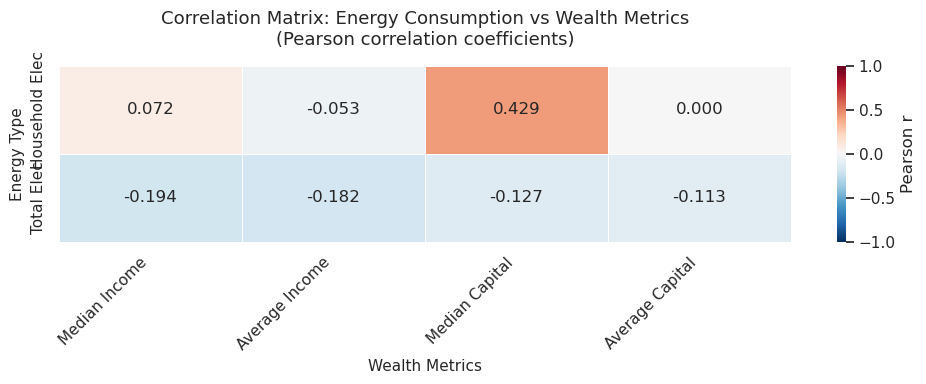

Correlation heatmap saved.


In [46]:
# --- Pearson-Korrelations-Heatmap -------------------------------------------------
# Erstellt eine kompakte Matrixvisualisierung, die alle Korrelationen auf einen Blick zeigt
import matplotlib.pyplot as plt
import seaborn as sns

# Legt eine Liste an, die später die 2xN-Pearson-Matrix bildet
corr_matrix = []
# Kürzere Achsentexte für die Energievariablen halten die Heatmap gut lesbar
energy_labels_short = ['Household Elec', 'Total Elec']
# Erzeugt kurze Vermögenslabel aus dem Wörterbuch, um Achsenbeschriftungen kompakt zu halten
wealth_labels_short = [
    wealth_labels.get(col, col).replace(' (CHF)', '').replace(' 2022', '')
    for col in wealth_cols
]

# Befüllt die Matrix energie-spaltenweise Zeile für Zeile
for energy_col in energy_cols:
    row = []
    for wealth_col in wealth_cols:
        # Entfernt NaN-Werte, damit nur gültige Paare in die Korrelation eingehen
        df = merged[[energy_col, wealth_col]].dropna()
        if df.empty or len(df) < 3:
            # Trägt NaN ein, wenn für dieses Paar zu wenige Daten vorhanden sind
            row.append(np.nan)
        else:
            # Ermittelt den Pearson-r für diese Kombination und hängt ihn an
            pr, _ = pearsonr(df[energy_col], df[wealth_col])
            row.append(pr)
    # Hängt die fertig gefüllte Zeile an die Gesamttabelle an
    corr_matrix.append(row)

# Überführt die verschachtelten Listen in ein DataFrame, das Seaborn direkt zeichnen kann
fig, ax = plt.subplots(figsize=(10, 4))
corr_df_heatmap = pd.DataFrame(corr_matrix,
                                index=energy_labels_short,
                                columns=wealth_labels_short)

# Zeichnet die Heatmap mit Beschriftungen, divergierender Farbpalette und einheitlicher Skalierung
sns.heatmap(corr_df_heatmap, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'},
            linewidths=0.5, ax=ax)

# Fügt aussagekräftige Titel und Achsenbeschriftungen für Kontext hinzu
plt.title('Correlation Matrix: Energy Consumption vs Wealth Metrics
(Pearson correlation coefficients)',
         fontsize=13, pad=15)
plt.xlabel('Wealth Metrics', fontsize=11)
plt.ylabel('Energy Type', fontsize=11)
plt.xticks(rotation=45, ha='right')
# Reduziert den Weißraum vor dem Speichern auf die Festplatte
plt.tight_layout()
plt.savefig('/home/jovyan/work/outputs/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Bestätigt im Notebook-Ausgabefeld, dass der Schritt abgeschlossen ist
print('Correlation heatmap saved.')



In [47]:
# --- Historische Scatterplots Haushaltsverbrauch vs. jede Vermögenskennzahl --------
# Setzt den Seaborn-Kontext zurück, falls frühere Zellen globale Stile geändert haben
sns.set_context('notebook')
for col in wealth_cols:
    if col not in merged.columns:
        # Überspringt Vermögensspalten, die im kombinierten Datensatz fehlen
        continue
    # Löscht Beobachtungen, denen für eine der beiden Achsenwerte Daten fehlen
    df = merged[['consum_per_capita_mwh_2024', col]].dropna()
    if df.empty:
        # Springt zur nächsten Kennzahl, wenn keine gültigen Datenpunkte übrig sind
        continue
    # Beginnt ein neues Diagramm für die jeweils betrachtete Vermögenskennzahl
    plt.figure(figsize=(6,5))
    # Zeichnet einen Scatterplot mit Regressionsgerade, um den Zusammenhang sichtbar zu machen
    sns.regplot(data=df, x='consum_per_capita_mwh_2024', y=col, scatter_kws={'alpha':0.6})
    # Vergibt einen beschreibenden Titel und Achsenbezeichnungen, die sich an den Originalspalten orientieren
    plt.title(f'Energy per capita vs {col}')
    plt.xlabel('Energy per capita (MWh) 2024')
    plt.ylabel(col)
    # Strafft das Layout, bevor die Grafik gespeichert wird
    plt.tight_layout()
    # Speichert die Grafik im Ordner outputs/figures mit einem metrikspezifischen Dateinamen
    plt.savefig(f'/home/jovyan/work/outputs/figures/scatter_{col}.png', dpi=150)
    plt.close()
# Gibt aus, dass dieser Stapel an Scatterplots fertiggestellt wurde
print('Saved scatter plots.')



Saved scatter plots.


In [48]:
# --- Ausreißererkennung über Regressionsresiduen ----------------------------------
# Erläutert die Methode, mit der abweichende Gemeinden identifiziert werden
# Ausreißer werden über Residuen einer linearen Regression erkannt
from sklearn.preprocessing import StandardScaler

# Sammelt die Residuen- bzw. Z-Score-Tabellen je Vermögenskennzahl in einer Liste
outlier_rows = []
for col in wealth_cols:
    # Behält BFS-IDs sowie die beiden Regressionsvariablen und entfernt Zeilen mit NaN
    df = merged[['bfs_nr','consum_per_capita_mwh_2024', col]].dropna()
    if df.shape[0] < 10:
        # Überspringt Kennzahlen mit zu geringer Stichprobe für eine Regression
        continue
    # Baut die Prädiktormatrix (Vermögen) sowie den Zielvektor (Energieverbrauch) auf
    X = df[[col]].values.reshape(-1,1)
    y = df['consum_per_capita_mwh_2024'].values
    # Passt ein einfaches lineares Regressionsmodell an, das Energie aus der Vermögenskennzahl vorhersagt
    model = LinearRegression().fit(X, y)
    # Erzeugt für jede Gemeinde die prognostizierten Energieverbrauchswerte
    y_pred = model.predict(X)
    # Berechnet Residuen, um Abweichungen ober- oder unterhalb der Regressionsgeraden zu messen
    resid = y - y_pred
    # Standardisiert die Residuen zu Z-Scores, damit Abweichungen zwischen Kennzahlen vergleichbar sind
    z = (resid - resid.mean()) / (resid.std(ddof=1) if resid.std(ddof=1) else 1.0)
    # Speichert BFS-Nummern gemeinsam mit Residuen und Z-Scores für die Kennzahl
    df_out = pd.DataFrame({'bfs_nr': df['bfs_nr'].values, 'metric': col, 'residual': resid, 'zscore': z})
    outlier_rows.append(df_out)

# Fasst die Ergebnisse je Metrik zusammen oder erzeugt ein leeres DataFrame, falls nichts anfiel
outliers = pd.concat(outlier_rows, ignore_index=True) if outlier_rows else pd.DataFrame(columns=['bfs_nr','metric','residual','zscore'])
# Sortiert nach absolutem Z-Score, damit die stärksten positiven wie negativen Abweichungen oben erscheinen
outliers_sorted = outliers.reindex(outliers['zscore'].abs().sort_values(ascending=False).index)
# Speichert die Rohresultate zur externen Prüfung oder Nachvollziehbarkeit
outliers.to_csv('/home/jovyan/work/outputs/outliers.csv', index=False)
# Zeigt die extremsten Fälle für den Nutzer an
outliers_sorted.head(10)



,bfs_nr,metric,residual,zscore
175,23,income_avg_2022,1.345592,2.661078
495,23,capital_avg_2022,1.305576,2.578287
15,23,income_median_2022,1.291666,2.557485
340,28,capital_median_2022,1.056990,2.310994
351,43,capital_median_2022,1.026745,2.244867
371,70,capital_median_2022,0.949422,2.075810
347,38,capital_median_2022,0.949319,2.075584
51,70,income_median_2022,1.046641,2.072338
31,43,income_median_2022,1.046377,2.071815
531,70,capital_avg_2022,1.041190,2.056170


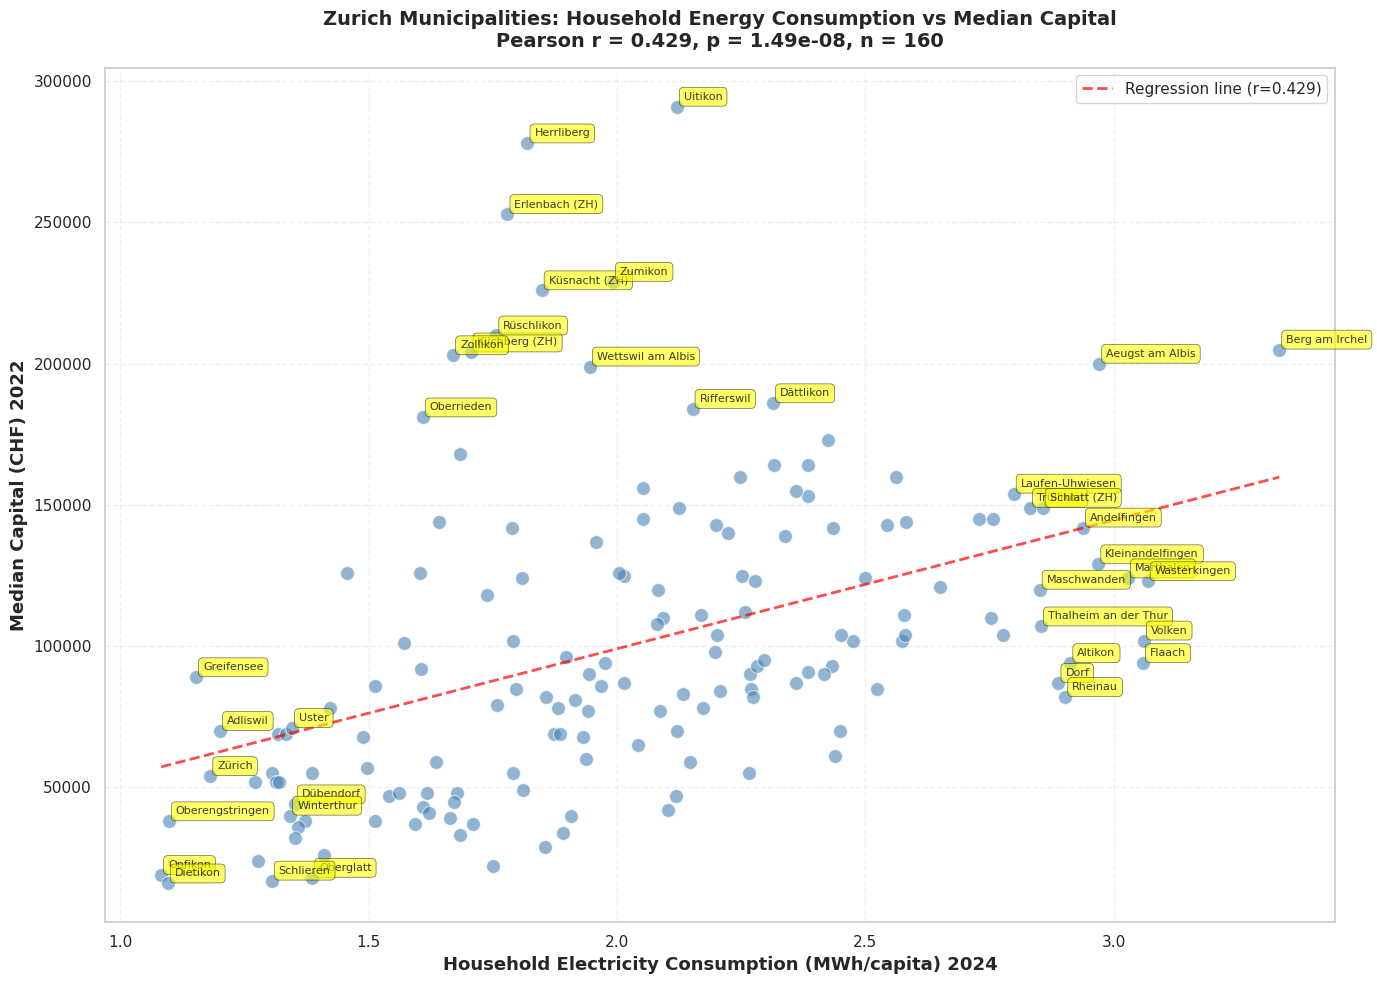

Scatter plot saved with 39 municipalities labeled (outliers and major cities).
Total municipalities in plot: 160


In [49]:
# --- Hervorgehobener Scatterplot Haushaltsenergie vs. Medianvermögen ---------------
# Erstellt einen präsentationsreifen Scatterplot mit annotierten Schlüsselgemeinden
if 'household_elec_per_capita_mwh_2024' in merged.columns and 'capital_median_2022' in merged.columns:
    # Reduziert den DataFrame auf die für die Grafik benötigten Spalten und entfernt fehlende Werte
    df_plot = merged[['bfs_nr', 'municipality', 'household_elec_per_capita_mwh_2024', 'capital_median_2022']].dropna()

    if not df_plot.empty:
        # Wählt eine großzügige Zeichenfläche, damit Beschriftungen gut lesbar bleiben
        fig, ax = plt.subplots(figsize=(14, 10))

        # Zeichnet einen Scatterplot, in dem jede Gemeinde als gleich formatierter Punkt erscheint
        scatter = ax.scatter(df_plot['household_elec_per_capita_mwh_2024'],
                            df_plot['capital_median_2022'],
                            alpha=0.6, s=100, c='steelblue', edgecolors='white', linewidth=0.8)

        # Legt Schwellenwerte fest, damit nur Ausreißer oder besonders interessante Punkte beschriftet werden
        energy_mean = df_plot['household_elec_per_capita_mwh_2024'].mean()
        energy_std = df_plot['household_elec_per_capita_mwh_2024'].std()
        capital_mean = df_plot['capital_median_2022'].mean()
        capital_std = df_plot['capital_median_2022'].std()

        # Markiert Gemeinden, die Ausreißer sind oder extreme Werte besitzen
        labeled_count = 0
        for idx, row in df_plot.iterrows():
            energy_z = abs((row['household_elec_per_capita_mwh_2024'] - energy_mean) / energy_std)
            capital_z = abs((row['capital_median_2022'] - capital_mean) / capital_std)
            # Beschriftet Punkte, wenn eine Dimension mehr als 1,5 Standardabweichungen abweicht oder es sich um eine wichtige Gemeinde handelt
            if energy_z > 1.5 or capital_z > 1.5 or row['municipality'] in ['Zürich', 'Winterthur', 'Uster', 'Dübendorf', 'Dietikon']:
                ax.annotate(text=row['municipality'],
                           xy=(row['household_elec_per_capita_mwh_2024'], row['capital_median_2022']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.9,
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.6, edgecolor='black', linewidth=0.5))
                labeled_count += 1

        # Zeichnet eine Regressionsgerade ein
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(
            df_plot['household_elec_per_capita_mwh_2024'],
            df_plot['capital_median_2022']
        )
        x_line = np.linspace(df_plot['household_elec_per_capita_mwh_2024'].min(),
                            df_plot['household_elec_per_capita_mwh_2024'].max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7,
               label=f'Regression line (r={r_value:.3f})')

        ax.set_xlabel('Household Electricity Consumption (MWh/capita) 2024', fontsize=13, fontweight='bold')
        ax.set_ylabel('Median Capital (CHF) 2022', fontsize=13, fontweight='bold')
        ax.set_title('Zurich Municipalities: Household Energy Consumption vs Median Capital
' +
                    f'Pearson r = {r_value:.3f}, p = {p_value:.2e}, n = {len(df_plot)}',
                    fontsize=14, pad=15, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.savefig('/home/jovyan/work/outputs/figures/household_energy_vs_median_capital.png',
                   dpi=150, bbox_inches='tight')
        plt.show()

        print(f'Scatter plot saved with {labeled_count} municipalities labeled (outliers and major cities).')
        print(f'Total municipalities in plot: {len(df_plot)}')
    else:
        # Meldet, wenn für die Visualisierung keine gültigen Datenpaare vorliegen
        print('No data available for scatter plot.')
else:
    # Gibt eine Warnung aus, wenn notwendige Spalten vollständig fehlen
    print('Required columns not found in merged data.')



## Summary of Analysis

This notebook analyzes the relationship between wealth metrics and energy consumption in Zurich municipalities.

### Data Sources
- **Energy**: Total and household electricity consumption per capita (2024)
- **Wealth**: Income and capital metrics (median, average, total per capita) from 2022
- **Geography**: Municipality boundaries for Zurich canton

### Analysis Performed

1. **Comprehensive Correlation Analysis**
   - Calculated Pearson and Spearman correlations for all combinations
   - Energy types: Household electricity, Total electricity
   - Wealth metrics: Income (median/avg/per capita), Capital (median/avg/per capita)
   - Results saved to `comprehensive_correlations.csv`

2. **Visualizations**
   - Scatter plots with wealth metrics on Y-axis and energy consumption on X-axis
   - Correlation heatmap showing all relationships at once
   - Choropleth maps showing spatial distribution of metrics
   - All figures saved to `outputs/figures/` and `outputs/maps/`

3. **Outlier Detection**
   - Identified municipalities with unusual energy consumption patterns
   - Based on regression residuals and z-scores

### Key Findings
Check the correlation tables and plots to identify:
- Which wealth metrics correlate most strongly with energy consumption
- Whether household or total electricity shows stronger correlations
- Spatial patterns in the relationship between wealth and energy use